
# Handwritten Character Classifier

## Introduction

In this project, we implement a Convolutional Neural Network (CNN) and a Random Forest Classifier to classify handwritten characters and digits. The goal is to create an efficient model that can accurately classify input images into one of the predefined categories, using state-of-the-art machine learning techniques.

### Objective
The main objective of this project is to design, implement, and compare both a CNN and Random Foreset Archetecture to understand each methods strengths and weaknesses.




#Configure the Enviroment

In [12]:
# Required Imports
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import functional as TF
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from abc import ABC, abstractmethod




#Preparing the Data

### **Data Preparation and Processing**

In this section, we will perform several crucial steps to prepare the data for training our Convolutional Neural Network (CNN). The **EMNIST** dataset will be used for handwritten character recognition. The following steps outline the process:

1. **Downloading the EMNIST Dataset**: The dataset consists of handwritten letters and will be split into training and testing datasets. We will download the data and apply basic transformations to prepare it for training.

2. **Visualizing Sample Data**: We'll display a few examples from the dataset to get an idea of what the data looks like before processing.

3. **Image Orientation and Transformations**: A custom transformation will be applied to the images, which includes rotating and flipping the images to standardize their orientation. Additional normalization will also be applied to help with model training.

4. **Calculating Dataset Statistics**: The mean and standard deviation of the training dataset will be calculated, which will be used for normalizing the images during training.

5. **Processing and Sharding the Dataset**: To make it manageable and optimize training, the dataset will be divided into smaller chunks (shards). These shards will be saved as separate files, ready for use during model training.

6. **Displaying Shard Samples**: After the dataset has been processed and saved in shards, we will display a sample image from one of the saved shards to ensure everything has been processed correctly.

By the end of this section, the data will be preprocessed, normalized, and split into manageable shards, ready for use in training our model.


### Download the EMNIST Dataset

In [4]:
# ----- Configurations -----
ROOT = Path('./data')
OUTPUT_DIR = Path('./data/processed')
BATCH_SIZE = 1024
SHARD_SIZE = 10000
NUM_WORKERS = 4

# Download the EMNIST dataset (Letters)
train_dataset = torchvision.datasets.EMNIST(
    root='./data',
    split='letters',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_dataset = torchvision.datasets.EMNIST(
    root='./data',
    split='letters',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# Check the dataset size
print(f'Training set size: {len(train_dataset)}')
print(f'Testing set size: {len(test_dataset)}')


Training set size: 124800
Testing set size: 20800


### Visualize Some Samples

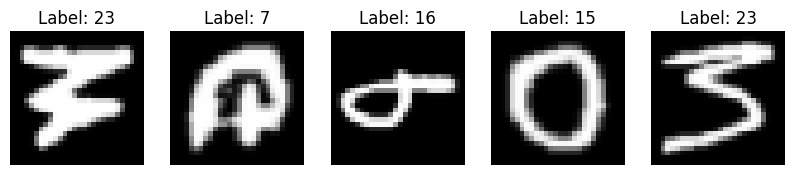

In [5]:
# Visualize some samples from the dataset
def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        image, label = dataset[i]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')

show_samples(train_dataset, num_samples=5)

### Image Orientation and Transformation Functions

In [6]:
def orient_images(img):
    # Rotate the image by 90 degrees clockwise
    oriented_image = TF.rotate(img, -90)
    # Flip the image horizontally
    oriented_image = TF.hflip(oriented_image)
    return oriented_image

def make_tf(mean, std):
    ops = [
        transforms.Lambda(orient_images),
        transforms.ToTensor()
    ]
    if mean is not None and std is not None:
        ops += [transforms.Normalize([mean], [std])]
    return transforms.Compose(ops)


### Compute Mean and Standard Deviation

In [7]:
# Compute the mean and std of the dataset
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples
    return mean.item(), std.item()

# Compute mean and std of the training set
mean, std = compute_mean_std(train_dataset)
print(f'Computed Mean: {mean}, Std: {std}')


Computed Mean: 0.17222730815410614, Std: 0.3241918385028839


### Process and Save the Dataset in Shards


In [8]:
# Remap labels from 1-26 to 0-25
def remap_labels(label):
    return label - 1

# Process and save the dataset in shards
def process_and_save_dataset(dataset, split_name, mean, std):
    output_dir = OUTPUT_DIR / split_name
    output_dir.mkdir(parents=True, exist_ok=True)

    tf = make_tf(mean, std)
    dataset.transform = tf

    num_shards = (len(dataset) + SHARD_SIZE - 1) // SHARD_SIZE

    for shard_idx in range(num_shards):
        start_idx = shard_idx * SHARD_SIZE
        end_idx = min((shard_idx + 1) * SHARD_SIZE, len(dataset))
        shard_data = []

        for i in range(start_idx, end_idx):
            image, label = dataset[i]
            label = remap_labels(label)
            shard_data.append((image.numpy(), label))

        shard_path = output_dir / f'shard_{shard_idx:03d}.pt'
        torch.save(shard_data, shard_path)
        print(f'Saved {shard_path} with {len(shard_data)} samples.')

# Process and save the training and test datasets
process_and_save_dataset(train_dataset, 'train', mean, std)
process_and_save_dataset(test_dataset, 'test', mean, std)


Saved data\processed\train\shard_000.pt with 10000 samples.
Saved data\processed\train\shard_001.pt with 10000 samples.
Saved data\processed\train\shard_002.pt with 10000 samples.
Saved data\processed\train\shard_003.pt with 10000 samples.
Saved data\processed\train\shard_004.pt with 10000 samples.
Saved data\processed\train\shard_005.pt with 10000 samples.
Saved data\processed\train\shard_006.pt with 10000 samples.
Saved data\processed\train\shard_007.pt with 10000 samples.
Saved data\processed\train\shard_008.pt with 10000 samples.
Saved data\processed\train\shard_009.pt with 10000 samples.
Saved data\processed\train\shard_010.pt with 10000 samples.
Saved data\processed\train\shard_011.pt with 10000 samples.
Saved data\processed\train\shard_012.pt with 4800 samples.
Saved data\processed\test\shard_000.pt with 10000 samples.
Saved data\processed\test\shard_001.pt with 10000 samples.
Saved data\processed\test\shard_002.pt with 800 samples.


### Verify Shards Work by displaying a sample from the shard

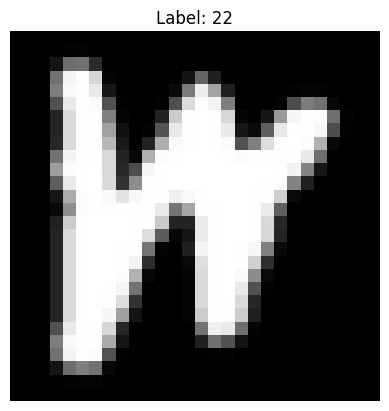

In [10]:
# Show a sample from a saved shard
def show_image(image, label):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

def display_sample_from_shard(shard_path, sample_idx=0):
    shard_data = torch.load(shard_path, weights_only=False, map_location='cpu')
    image, label = shard_data[sample_idx]
    show_image(image, label)

# Example of displaying the first sample from the first shard of the training data
display_sample_from_shard(OUTPUT_DIR / 'train' / 'shard_000.pt', sample_idx=0)


#CNN Model Definition and Training

In this section, we define and implement the architecture for the Convolutional Neural Network (CNN) used in this project. The primary goal of the CNN is to classify handwritten characters into predefined categories. The following steps outline what is being done:

## Defining the CNN Class:
We define the CNN architecture by subclassing torch.nn.Module. This class contains the layers, activations, and forward pass operations that are required for the model to process input images and output class predictions.

##Model Layers:
The CNN architecture includes several convolutional layers followed by batch normalization and activation functions (ReLU). We also include max pooling layers to reduce the spatial dimensions of the feature maps.

## Fully Connected Layers:
After the convolutional layers, the feature maps are flattened and passed through fully connected (linear) layers. These layers are used to classify the output into one of the 26 classes corresponding to different characters.

## Forward Pass:
The forward method defines how the input is passed through the network. It includes the operations from the input layer through to the final output layer, which gives the prediction scores for each class.

## Training the Model:
The model is trained using the backpropagation algorithm. In this section, we initialize the model, set the loss function (cross-entropy loss), and define the optimizer. We then train the model on batches of data for several epochs, adjusting the weights based on the calculated gradients.

## Evaluation:
After training, the model is evaluated on the test dataset to check its performance and accuracy. We also save the best-performing model during training.

By the end of this section, we will have a trained CNN model that can classify handwritten characters, which can be used for inference or further improvements.

### Abstract CNN Class

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple
from dataclasses import dataclass

@dataclass
class CNNConfig:
    input_channels: int
    num_classes: int
    conv_layers: Tuple[int, int, int]  # (out_channels, kernel_size, stride)
    dropout: Optional[float] = None

class AbstractCNN(nn.Module, ABC):
    def __init__(self, config: CNNConfig):
        super().__init__()
        self.config = config
        self.layers: nn.Sequential
        self.classifier: nn.Module
        self.dropout: nn.Module = nn.Identity()
        self.build()

    @abstractmethod
    def build(self) -> nn.Sequential:
        pass

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layers(x)
        x = x.mean(dim=[2, 3])  # Global Average Pooling
        if self.dropout:
            x = self.dropout(x)
        x = self.classifier(x)
        return x


### Simple CNN Implementation

In [14]:
class SimpleCNN(AbstractCNN):
    def build(self) -> nn.Sequential:
        c = self.config
        w1, w2, w3 = c.conv_layers

        # Block 1 28x28 -> 14x14
        self.b1 = nn.Sequential(
            nn.Conv2d(c.input_channels, w1, 3, padding=1, bias=False),
            nn.BatchNorm2d(w1),
            nn.ReLU(inplace=True),
            nn.Conv2d(w1, w1, 3, padding=1, bias=False),
            nn.BatchNorm2d(w1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        # Block 2 14x14 -> 7x7
        self.b2 = nn.Sequential(
            nn.Conv2d(w1, w2, 3, padding=1, bias=False),
            nn.BatchNorm2d(w2),
            nn.ReLU(inplace=True),
            nn.Conv2d(w2, w2, 3, padding=1, bias=False),
            nn.BatchNorm2d(w2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        # Feature Head 7x7 -> 7x7
        self.head = nn.Sequential(
            nn.Conv2d(w2, w3, 3, padding=1, bias=False),
            nn.BatchNorm2d(w3),
            nn.ReLU(inplace=True)
        )

        # Combine all layers
        self.layers = nn.Sequential(
            self.b1,
            self.b2,
            self.head
        )

        # Classifier
        if c.dropout:
            self.dropout = nn.Dropout(c.dropout)
        self.classifier = nn.Linear(w3, c.num_classes)


### Sample Model and Testing Output

In [15]:
# Example usage
cfg = CNNConfig(input_channels=1, num_classes=26, conv_layers=(32, 64, 128), dropout=0.3)
model = SimpleCNN(cfg)
x = torch.randn(8, 1, 28, 28)        # batch of 8, preprocessed images
y = model(x)
print("logits shape:", y.shape)      # expect [8, 26]
print("param count:", sum(p.numel() for p in model.parameters()))


logits shape: torch.Size([8, 26])
param count: 142522


### Data Loader from Shards

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import List, Sequence

class PTShardDataset(Dataset):
    def __init__(self, shard_paths: Sequence[Path]):
        self.items: List[tuple] = []
        for p in shard_paths:
            chunk = torch.load(p, map_location='cpu', weights_only=False)
            if not isinstance(chunk, list):
                raise ValueError(f"Expected list in shard {p}, got {type(chunk)}")
            self.items.extend(chunk)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        x_np, y = self.items[idx]
        x = torch.as_tensor(x_np, dtype=torch.float32)
        if x.ndim == 2:
            x = x.unsqueeze(0)  # Add channel dimension for grayscale images
        elif x.ndim == 3 and x.shape[0] != 1:
            x = x.permute(2, 0, 1).contiguous()  # Change HWC to CHW

        y = int(y)

        return x, y

    @staticmethod
    def create_dataloader(proc_dir: Path, batch_train=128, batch_eval=256, val_frac=0.1, seed=42):
        train_dir = proc_dir / 'train'
        test_dir = proc_dir / 'test'

        train_shards = sorted(train_dir.glob('shard_*.pt'))
        test_shards = sorted(test_dir.glob('shard_*.pt'))

        full_train = PTShardDataset(train_shards)
        test = PTShardDataset(test_shards)

        if not train_shards or not test_shards:
            raise FileNotFoundError(f"No shards found in {train_dir} or {test_dir}")

        # Split training shards into training and validation sets
        num_val_shards = int(len(full_train) * val_frac)
        num_train_shards = len(full_train) - num_val_shards

        g = torch.Generator().manual_seed(seed)
        train_ds, val_ds = torch.utils.data.random_split(
            full_train, [num_train_shards, num_val_shards], generator=g
        )

        train_loader = DataLoader(train_ds, batch_size=batch_train, shuffle=True, num_workers=4, pin_memory=False)
        val_loader = DataLoader(val_ds, batch_size=batch_eval, shuffle=False, num_workers=4, pin_memory=False)
        test_loader = DataLoader(test, batch_size=batch_eval, shuffle=False, num_workers=4, pin_memory=False)

        return train_loader, val_loader, test_loader

### Training and Evaluation Functions

In [18]:
import torch
import torch.nn as nn
import numpy as np

def run_epoch(model, loader, criterion, optimizer=None, device='cpu'):
    train = optimizer is not None
    model.train(train)
    total, correct, loss = 0, 0, 0.0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = torch.as_tensor(y, device=device)

        if train:
            optimizer.zero_grad(set_to_none=True)

        logits = model(x)
        loss = criterion(logits, y)

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

    return loss / total, correct / total

def evaluate_confusion(model, loader, num_classes, device='cpu'):
    model.eval()
    confusion = np.zeros((num_classes, num_classes), dtype=np.int64)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = torch.as_tensor(y, device=device)

            logits = model(x)
            pred = logits.argmax(dim=1)

            for t, p in zip(y.view(-1), pred.view(-1)):
                confusion[int(t), int(p)] += 1

    per_class_acc = confusion.diagonal() / np.clip(confusion.sum(axis=1), 1, a_max=None)

    return confusion, per_class_acc


### Model Training and Saving Best Model

In [ ]:
# Training loop and evaluation for the model
train_loader, val_loader, test_loader = PTShardDataset.create_dataloader(Path('./data/processed'), batch_train=128, batch_eval=256)

model = SimpleCNN(CNNConfig(input_channels=1, num_classes=26, conv_layers=(32,64,128), dropout=0.3)).to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

epochs = 15
best_val = 0.0
save_path = Path('best_model.pt')

for epoch in range(1, epochs + 1):
    train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device='cpu')
    val_loss, val_acc = run_epoch(model, val_loader, criterion, None, device='cpu')

    prev_lr = optimizer.param_groups[0]["lr"]
    scheduler.step(val_acc)  # uses validation accuracy
    curr_lr = optimizer.param_groups[0]["lr"]
    if curr_lr != prev_lr:
        print(f"LR reduced: {prev_lr:.2e} -> {curr_lr:.2e}")

    print(f'Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}')

    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), save_path)
        print(f'New best model saved with Val Acc={best_val:.4f}')


### Model Evaluation and Test Accuracy

In [ ]:
import matplotlib.pyplot as plt
import string
import json

def test_model(model, test_loader, device='cpu'):
    model.eval()
    total, correct = 0, 0

    correct_by_class = {}

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device, non_blocking=True)
            y = torch.as_tensor(y, device=device)

            logits = model(x)
            pred = logits.argmax(dim=1)

            correct += (pred == y).sum().item()
            total += x.size(0)

            for t, p in zip(y.view(-1), pred.view(-1)):
                t = int(t)
                if t not in correct_by_class:
                    correct_by_class[t] = {'correct': 0, 'total': 0}
                if t == int(p):
                    correct_by_class[t]['correct'] += 1
                correct_by_class[t]['total'] += 1

    overall_acc = correct / total
    print(f'Test Accuracy: {overall_acc * 100:.2f}%')
    for cls, stats in correct_by_class.items():
        class_acc = stats['correct'] / stats['total']
        print(f'Class {cls}: Accuracy: {class_acc * 100:.2f}%')

    return overall_acc, correct_by_class

# Example usage for evaluation
model.load_state_dict(torch.load('best_model.pt', map_location='cpu'))
_, _, test_loader = PTShardDataset.create_dataloader(Path('./data/processed'), batch_train=128, batch_eval=256)
overall_acc, correct_by_class = test_model(model, test_loader, device='cpu')

# Plot the test accuracy by class
num_classes = 26
letters = list(string.ascii_uppercase)

acc = []
for i in range(num_classes):
    if i in correct_by_class:
        stats = correct_by_class[i]
        class_acc = stats['correct'] / stats['total']
    else:
        class_acc = 0.0
    acc.append(class_acc * 100)

plt.bar(range(num_classes), acc)
plt.xticks(range(num_classes), letters)
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Test Accuracy by Class')
plt.xticks(rotation=45)
plt.tight_layout()


# Random Forest Model Training and Evaluation

In this section, we define and train a Random Forest model to classify handwritten characters from the EMNIST dataset. We also evaluate its performance on the test set, compute the accuracy, and display the results using visualizations.

## RFModel Class:

A wrapper around the RandomForestClassifier from sklearn. This class handles training, prediction, saving, loading, and extracting feature importances from the trained model.

It includes methods for fitting the model to training data, making predictions, saving the trained model to disk, and loading it back.

## Training Pipeline:

The data is loaded from shards using the PTShardDataset class, which is similar to the one used for the CNN model.

The training data is converted to numpy arrays and passed to the RandomForestClassifier for training.

After training, the model is saved and evaluated on both the validation and test datasets.

## Evaluation:

The model's performance is evaluated using accuracy and per-class accuracy.

We also visualize the per-class accuracy for the test set using a bar chart.

### RF Model Class and Training